1. Importar bibliotecas y clases necesarias


In [10]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from typing import List
import numpy as np
from multiprocessing import freeze_support
from utils.mobility_data_manager import DataManager
from scipy.interpolate import CubicSpline
from utils.metrics import Metric, DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric


class MobilityDataExtractor:
    """
    Clase para extraer datos de entrenamiento y validación de los conjuntos de datos de movilidad.
    """

    @staticmethod
    def limit_dataset_days(dataset, max_days):
        """
        Limita el conjunto de datos a un número específico de días.

        Args:
            dataset: El conjunto de datos completo.
            max_days: Número máximo de días a considerar.

        Returns:
            Un subconjunto del dataset limitado en días.
        """
        return dataset[:, :max_days, :, :]

    @staticmethod
    def extract_training_data_slice(dataset, num_dias, num_usuarios):
        """
        Extrae una porción de los datos de entrenamiento excluyendo el cuadrante inferior derecho.
        """
        total_usuarios, total_dias, pings_por_dia, coordenadas = dataset.shape

        matriz_sin_cuadrante_inf_derecho = np.full(
            (total_usuarios, total_dias, pings_por_dia, coordenadas),
            np.nan,
            dtype=dataset.dtype,
        )

        matriz_sin_cuadrante_inf_derecho[:num_usuarios, :num_dias] = dataset[
            :num_usuarios, :num_dias
        ]
        return matriz_sin_cuadrante_inf_derecho

    @staticmethod
    def extract_validation_data_slice(dataset, num_dias, num_usuarios):
        """
        Extrae la porción de los datos de validación del cuadrante inferior derecho.
        """
        return dataset[-num_usuarios:, -num_dias:, :, :]

    @staticmethod
    def create_training_validation_sets(dataset, val_dias, usuario_cutoff):
        """
        Crea los conjuntos de entrenamiento y validación a partir del conjunto de datos.
        """
        total_dias = dataset.shape[1]
        train_dias = total_dias - val_dias
        usuarios_restantes = dataset.shape[0] - usuario_cutoff
        training_set = MobilityDataExtractor.extract_training_data_slice(
            dataset, train_dias, usuario_cutoff
        )
        validation_set = MobilityDataExtractor.extract_validation_data_slice(
            dataset, val_dias, usuarios_restantes
        )
        return training_set, validation_set


class Predictor(ABC):
    @abstractmethod
    def predict(self, data, val_dias, usuario_offset):
        pass


class NaiveWeekRepeatPredictor(Predictor):
    def predict(self, data, val_dias, usuario_offset):
        """
        Genera predicciones para la región de validación usando la semana anterior.
        """
        usuarios_restantes = data.shape[0] - usuario_offset
        pings_por_dia, coordenadas = data.shape[2], data.shape[3]
        num_dias = data.shape[1]

        predicciones = np.empty(
            (usuarios_restantes, val_dias, pings_por_dia, coordenadas)
        )
        predicciones[:] = np.nan

        for usuario in range(usuarios_restantes):
            for dia in range(val_dias):
                semana_pasada = dia % 7
                x = usuario_offset + usuario
                y = num_dias - val_dias - 7 + semana_pasada  # Días anteriores correctos
                coord_semana_pasada = data[x, y]
                predicciones[usuario, dia] = self._complete_missing_values(
                    coord_semana_pasada
                )
                predict_actual = predicciones[usuario, dia]
                if np.any(np.isnan(predict_actual)):
                    print("WARNING: Hay valores NaN en las predicciones.")

        return predicciones

    def _complete_missing_values(self, day_data):
        """
        Completa los valores faltantes (NaN) en los datos diarios usando interpolación cúbica
        y regresión polinómica para extrapolación.

        Args:
            day_data: Arreglo de shape (pings_por_dia, coordenadas) con los datos de un día.

        Returns:
            Arreglo completado sin valores NaN, con interpolación cúbica y extrapolación polinómica.
        """
        completed_data = day_data.copy()
        for coord in range(
            completed_data.shape[1]
        ):  # Itera sobre cada coordenada (x e y)
            values = completed_data[:, coord]
            indices = np.arange(len(values))

            # Detectar valores válidos y NaN
            valid_indices = ~np.isnan(values)
            if valid_indices.sum() == 0:  # Caso extremo: todos son NaN
                completed_data[:, coord] = 0  # Asigna cero a todos
                continue

            valid_x = indices[valid_indices]  # Índices de valores válidos
            valid_y = values[valid_indices]  # Valores válidos

            # Interpolación cúbica si hay suficientes puntos
            if len(valid_x) > 1:
                cs = CubicSpline(valid_x, valid_y, extrapolate=False)
                interpolated = cs(indices)
            else:
                # Si solo hay un valor válido, rellenar todo con ese valor
                interpolated = np.full_like(values, valid_y[0])

            # Extrapolación para los extremos NaN (usando regresión lineal simple)
            nan_start = np.isnan(interpolated[: valid_x[0]])  # NaN al inicio
            nan_end = np.isnan(interpolated[valid_x[-1] + 1 :])  # NaN al final

            # Extrapolación al inicio
            if nan_start.any():
                slope_start = (
                    (valid_y[1] - valid_y[0]) / (valid_x[1] - valid_x[0])
                    if len(valid_x) > 1
                    else 0
                )
                interpolated[: valid_x[0]] = valid_y[0] + slope_start * (
                    indices[: valid_x[0]] - valid_x[0]
                )

            # Extrapolación al final
            if nan_end.any():
                slope_end = (
                    (valid_y[-1] - valid_y[-2]) / (valid_x[-1] - valid_x[-2])
                    if len(valid_x) > 1
                    else 0
                )
                interpolated[valid_x[-1] + 1 :] = valid_y[-1] + slope_end * (
                    indices[valid_x[-1] + 1 :] - valid_x[-1]
                )

            # Garantizar que los valores sean mayores o iguales a cero
            interpolated = np.maximum(interpolated, 0)

            interpolated = np.clip(interpolated, 0, 200)

            # Asignar los valores completados
            completed_data[:, coord] = interpolated

        return completed_data

    def _complete_missing_values_graphics(self, day_data):
        """
        Completa los valores faltantes (NaN) en los datos diarios usando interpolación cúbica
        y regresión lineal para extrapolación, y grafica la trayectoria completada.

        Args:
            day_data: Arreglo de shape (pings_por_dia, coordenadas) con los datos de un día.

        Returns:
            Arreglo completado sin valores NaN, con interpolación cúbica y extrapolación lineal.
        """
        completed_data = day_data.copy()
        for coord in range(
            completed_data.shape[1]
        ):  # Itera sobre cada coordenada (x e y)
            values = completed_data[:, coord]
            indices = np.arange(len(values))

            # Detectar valores válidos y NaN
            valid_indices = ~np.isnan(values)
            if valid_indices.sum() == 0:  # Caso extremo: todos son NaN
                completed_data[:, coord] = 0  # Asigna cero a todos
                continue

            valid_x = indices[valid_indices]  # Índices de valores válidos
            valid_y = values[valid_indices]  # Valores válidos

            # Interpolación cúbica
            if len(valid_x) > 1:
                cs = CubicSpline(valid_x, valid_y, extrapolate=False)
                interpolated = cs(indices)
            else:
                interpolated = np.full_like(values, valid_y[0])

            # Extrapolación lineal para los extremos
            nan_start = np.isnan(interpolated[: valid_x[0]])
            if nan_start.any():
                slope_start = (
                    (valid_y[1] - valid_y[0]) / (valid_x[1] - valid_x[0])
                    if len(valid_x) > 1
                    else 0
                )
                interpolated[: valid_x[0]] = valid_y[0] + slope_start * (
                    indices[: valid_x[0]] - valid_x[0]
                )

            nan_end = np.isnan(interpolated[valid_x[-1] + 1 :])
            if nan_end.any():
                slope_end = (
                    (valid_y[-1] - valid_y[-2]) / (valid_x[-1] - valid_x[-2])
                    if len(valid_x) > 1
                    else 0
                )
                interpolated[valid_x[-1] + 1 :] = valid_y[-1] + slope_end * (
                    indices[valid_x[-1] + 1 :] - valid_x[-1]
                )

            # Garantizar que los valores sean mayores o iguales a cero
            interpolated = np.maximum(interpolated, 0)

            # Asignar valores interpolados
            completed_data[:, coord] = interpolated

        # Graficar la trayectoria completa en el plano (x, y)
        plt.figure(figsize=(8, 6))
        valid_points = ~np.isnan(day_data[:, 0]) & ~np.isnan(day_data[:, 1])

        plt.plot(
            day_data[valid_points, 0],
            day_data[valid_points, 1],
            "ro",
            label="Puntos originales",
        )
        plt.plot(
            completed_data[:, 0],
            completed_data[:, 1],
            # "-o",
            color="blue",
            label="Trayectoria completada",
        )

        plt.title("Movimiento del usuario en el plano (x, y)")
        plt.xlabel("Coordenada X")
        plt.ylabel("Coordenada Y")
        plt.legend()
        plt.grid()
        plt.show()

        return completed_data


class Formatter:
    @staticmethod
    def __format_trajectory_data(data):
        formatted_data = []
        num_usuarios, num_dias, pings_por_dia, _ = data.shape
        for usuario in range(num_usuarios):
            user_trajectory = []
            for dia in range(num_dias):
                for ping in range(pings_por_dia):
                    point = (
                        dia,
                        ping,
                        data[usuario, dia, ping, 0],
                        data[usuario, dia, ping, 1],
                    )
                    user_trajectory.append(point)
            if user_trajectory:
                formatted_data.append(user_trajectory)
        return formatted_data

    @staticmethod
    def create_comparable_trajectories(predictions, validation):
        formatted_predictions = Formatter.__format_trajectory_data(predictions)
        formatted_validation = Formatter.__format_trajectory_data(validation)
        generated_per_user, reference_per_user = [], []

        for user_idx in range(len(formatted_validation)):
            user_predictions_data = formatted_predictions[user_idx]
            user_validation_data = formatted_validation[user_idx]
            prediction_dict = {
                (entry[0], entry[1]): (entry[2], entry[3])
                for entry in user_predictions_data
            }
            generated, reference = [], []
            for day, hour, ref_x, ref_y in user_validation_data:
                if not (np.isnan(ref_x) or np.isnan(ref_y)):
                    if (day, hour) in prediction_dict:
                        pred_x, pred_y = prediction_dict[(day, hour)]
                        if np.isnan(pred_x) or np.isnan(pred_y):
                            print(f"NaN prediction at {day}, {hour}")
                        generated.append((day, hour, pred_x, pred_y))
                        reference.append((day, hour, ref_x, ref_y))
            generated_per_user.append(generated)
            reference_per_user.append(reference)

        return generated_per_user, reference_per_user

2. Cargar el archivo HDF5


In [11]:
ruta_hdf5 = "../Data/cityA_groundtruthdata.csv/cityA_groundtruthdata.hdf5"

manager = DataManager()
dataset = manager.load_hdf5(ruta_hdf5)

dataset.shape

(100000, 75, 48, 2)

3. Preprocesar los datos


In [12]:
total_dias = 60
val_dias = 15
usuario_cutoff = dataset.shape[0] - 3000  # últimos 3000 usuarios

# Limitar días y crear conjuntos
dataset = MobilityDataExtractor.limit_dataset_days(dataset, total_dias)
training_set, validation_set = MobilityDataExtractor.create_training_validation_sets(
    dataset, val_dias, usuario_cutoff
)

print(f"Training set shape: {training_set.shape}")
print(f"Validation set shape: {validation_set.shape}")

Training set shape: (100000, 60, 48, 2)
Validation set shape: (3000, 15, 48, 2)


4. Generar predicciones


In [13]:
predictor = NaiveWeekRepeatPredictor()

# Generar predicciones
predicciones = predictor.predict(dataset, val_dias, usuario_offset=usuario_cutoff)

5. Graficar trayectorias


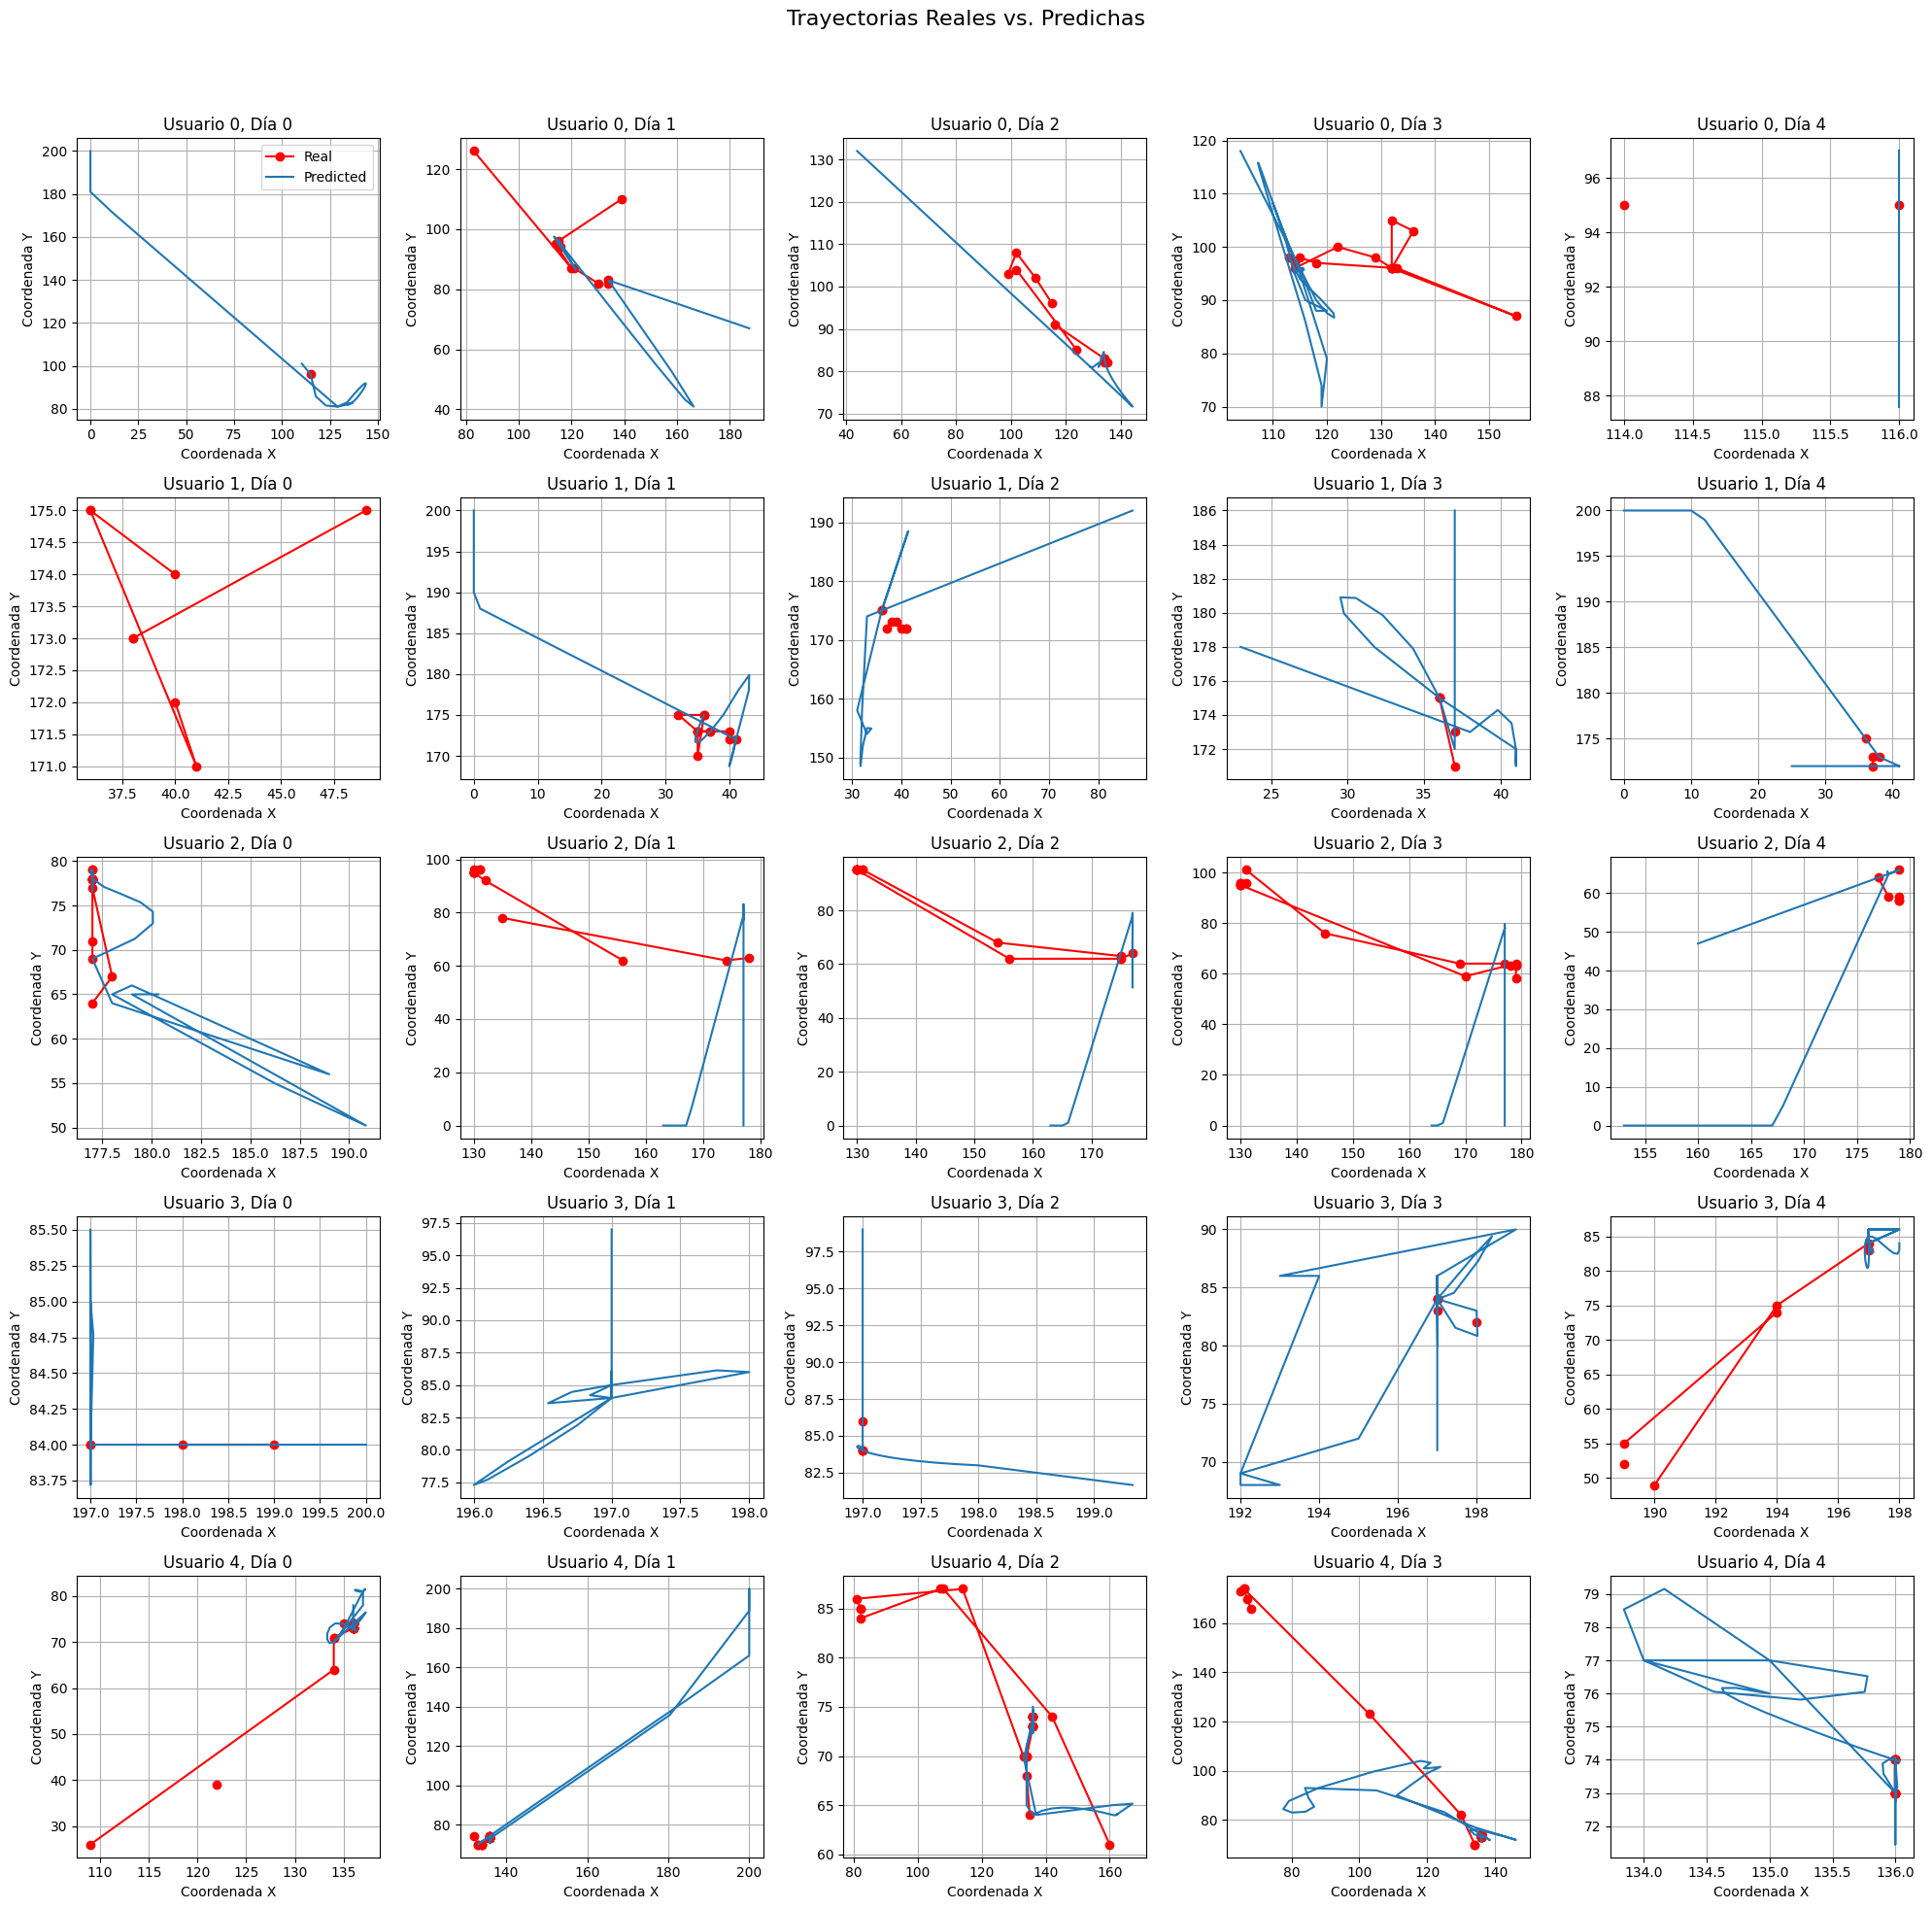

In [19]:
def plot_all_trajectories(real_data, predicted_data, max_users=5, max_days=5):
    """
    Grafica las trayectorias reales y predichas para múltiples usuarios y días.

    Args:
        real_data (numpy.ndarray): Trayectorias reales (usuarios, días, pings, coordenadas).
        predicted_data (numpy.ndarray): Trayectorias predichas (usuarios, días, pings, coordenadas).
        max_users (int): Número máximo de usuarios a graficar.
        max_days (int): Número máximo de días a graficar por usuario.
    """
    num_users = min(real_data.shape[0], max_users)  # Limitar número de usuarios
    num_days = min(real_data.shape[1], max_days)  # Limitar número de días

    # Crear una figura con subplots
    fig, axes = plt.subplots(num_users, num_days, figsize=(4 * num_days, 4 * num_users))
    fig.suptitle("Trayectorias Reales vs. Predichas", fontsize=16)

    # Si hay solo un usuario o un día, aseguramos que 'axes' sea un array bidimensional
    if num_users == 1:
        axes = np.expand_dims(axes, axis=0)
    if num_days == 1:
        axes = np.expand_dims(axes, axis=1)

    # Iterar sobre usuarios y días
    for user_idx in range(num_users):
        for day_idx in range(num_days):
            ax = axes[user_idx][day_idx]
            real = real_data[user_idx, day_idx]
            predicted = predicted_data[user_idx, day_idx]

            # Graficar trayectorias reales y predichas
            ax.plot(real[:, 0], real[:, 1], "ro-", label="Real")
            ax.plot(predicted[:, 0], predicted[:, 1], label="Predicted")

            # Configuración del subplot
            ax.set_title(f"Usuario {user_idx}, Día {day_idx}")
            ax.set_xlabel("Coordenada X")
            ax.set_ylabel("Coordenada Y")
            ax.grid(True)

            # Mostrar la leyenda solo en el primer gráfico
            if user_idx == 0 and day_idx == 0:
                ax.legend()

    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Graficar trayectorias para los primeros 5 usuarios y 5 días
plot_all_trajectories(validation_set, predicciones, max_users=5, max_days=5)

6. Calcular métricas y mostrar estadísticas


In [16]:
# Calcular métricas  DTWMetric(), GeoBLEUMetric()
metrics: list[Metric] = [
    LPPMetric(),
    MAEMetric(),
]
generated, reference = Formatter.create_comparable_trajectories(
    predicciones, validation_set
)

# Evaluación
for metric in metrics:
    score = metric.calculate(generated, reference)
    print(f"{metric.__class__.__name__} score: {score:.2f}")

LPPMetric score: 9.67
MAEMetric score: 25.31


7. Estadísticas de errores


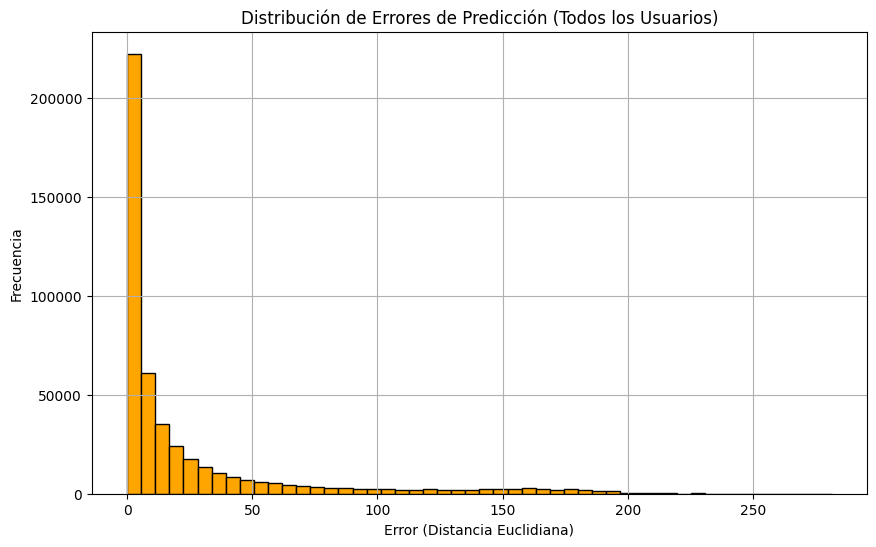

Error medio (MAE): 25.31
Error máximo: 281.43
Error mínimo: 0.00
Desviación estándar del error: 43.04


In [17]:
def calculate_error_statistics_all_users(validation_set, predictions):
    """
    Calcula la distancia euclidiana (errores) entre predicciones y valores reales para todos los usuarios y días.

    Args:
        validation_set (numpy.ndarray): Trayectorias reales (usuarios, días, pings, coordenadas).
        predictions (numpy.ndarray): Trayectorias predichas (usuarios, días, pings, coordenadas).

    Returns:
        list: Lista de errores (distancias euclidianas) válidos.
    """
    all_errors = []

    num_users, num_days, _, _ = validation_set.shape

    for user in range(num_users):  # Iterar sobre usuarios
        for day in range(num_days):  # Iterar sobre días
            real = validation_set[user, day]
            predicted = predictions[user, day]

            # Calcular errores para el usuario y día actuales
            errors = np.sqrt(
                np.sum((real - predicted) ** 2, axis=-1)
            )  # Distancia Euclidiana

            # Filtrar valores no válidos (NaN)
            valid_errors = errors[~np.isnan(errors)]
            all_errors.extend(valid_errors)

    return all_errors


def plot_error_distribution(errors):
    """
    Grafica la distribución de errores de predicción.

    Args:
        errors (list): Lista de errores válidos.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, color="orange", edgecolor="black")
    plt.title("Distribución de Errores de Predicción (Todos los Usuarios)")
    plt.xlabel("Error (Distancia Euclidiana)")
    plt.ylabel("Frecuencia")
    plt.grid()
    plt.show()


def print_error_statistics(errors):
    """
    Imprime estadísticas básicas de los errores.

    Args:
        errors (list): Lista de errores válidos.
    """
    print(f"Error medio (MAE): {np.mean(errors):.2f}")
    print(f"Error máximo: {np.max(errors):.2f}")
    print(f"Error mínimo: {np.min(errors):.2f}")
    print(f"Desviación estándar del error: {np.std(errors):.2f}")


# Calcular errores para todos los usuarios y días
all_errors = calculate_error_statistics_all_users(validation_set, predicciones)

# Graficar distribución de errores
plot_error_distribution(all_errors)

# Imprimir estadísticas de error
print_error_statistics(all_errors)